# Comparaison des modèles SARIMA, KNN et RF

## Basé avec la météo corrigée de l'ACP

**Nous pouvons donc comparer la performance des algorithmes classiques : KNN, RF avec le modèle SARIMA.**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
import itertools
import utils
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_percentage_error

from sklearn import preprocessing

In [2]:
#FILEPATH = 'clean_data//ener_conso_full.csv'
df = pd.read_csv('clean_data/ener_conso_full.csv', parse_dates=[0], index_col=0, squeeze=True)
df_acp = pd.read_csv('clean_data/df_acp.csv',index_col=0)
df_acp.index = pd.to_datetime(df_acp.index)

### Création des 3 granularités

In [3]:
df_mois= df.resample('M').sum()
df_jours = df.resample('D').sum()
df_3h = df.resample('3h').sum()

function_to_apply = {
    'rafales_sur_une_periode' : 'max',
    'pression_au_niveau_mer' : 'mean',
    'vitesse_du_vent_moyen' : 'mean',
    'temperature_c' : 'mean',
}


df_acp_mois= df_acp.resample('M').agg(function_to_apply)
df_acp_jours = df_acp.resample('D').agg(function_to_apply)
df_acp_3h = df_acp.resample('3h').agg(function_to_apply)

# Etude par mois

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df_acp_mois, df_mois, test_size=0.2, shuffle = False)

#### Instanciation des modèles et des params à tester

In [5]:
pls = PLSRegression ()
rf = RandomForestRegressor ()
knn = KNeighborsRegressor()

param_grid_pls = {'n_components': range(1,10), 'scale': [False, True]}

param_grid_rf = [{'n_estimators': [10, 50, 100, 250, 500, 1000],
                        'min_samples_leaf': [1, 3, 5],
                        'max_features': ['auto', 'sqrt', 'log2']}]

param_knn = {"n_neighbors":list(range(1,41)),
             "weights": ["uniform", "distance"],
             "metric" :['manhattan', 'chebyshev','minkowski']}

gridcvs = {}

for pgrid, clf, name in zip((param_grid_pls, param_grid_rf, param_knn),
                            (pls, rf, knn),
                            ('PLSRegression', 'RF', 'KNN')):
    gcv = GridSearchCV(clf, pgrid, cv=KFold(2), refit=True)
    gridcvs[name] = gcv

In [6]:
warnings.filterwarnings("ignore")

outer_cv = KFold(2)
outer_scores = {}
scaler = StandardScaler()
print('Calcul en cours...')
for keys, value in gridcvs.items():
    X_train_scaled =scaler.fit_transform(X_train)
    score = cross_val_score(value, X_train_scaled, y_train, cv = outer_cv)
    outer_scores[keys] = score
    print(f'{keys}:  R² = {100*score.mean():.2f} +/- {100*score.std():.2f}') 
print('Calcul terminé !')

Calcul en cours...
PLSRegression:  R² = 40.94 +/- 19.12
RF:  R² = 58.03 +/- 29.13
KNN:  R² = 42.65 +/- 21.67
Calcul terminé !


### Scaling et entrainement:

In [7]:
X_train_scaled =scaler.fit_transform(X_train)
X_test_scaled =scaler.fit_transform(X_test)

rf = gridcvs['RF'].fit(X_train_scaled, y_train)
knn = gridcvs['KNN'].fit(X_train_scaled, y_train)

### SARIMA

*NB : La saisonnalité (période 12) a été déterminé via des graphs de différenciation dans les notebooks précédents.*

In [8]:
import warnings
warnings.filterwarnings('ignore')
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
df_acp_mois = scaler.fit_transform(df_acp_mois)

params_results = {}
print("Calcul en cours...")

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_mois,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            exog = df_acp_mois
                                            )
            results = mod.fit()
            params_results['ARIMA{}x{}12'.format(param, param_seasonal)] = round(results.aic, 0)
        except:
            continue
best_params = min(params_results, key=params_results.get)

print(best_params, 'AIC :', params_results[best_params])
print("Calcul terminé.")

Calcul en cours...
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 AIC : 2499.0
Calcul terminé.


In [9]:
model=sm.tsa.SARIMAX(df_mois, order=(0,1,0) ,seasonal_order = (0, 1, 1, 12), exog = df_acp_mois)
sarima=model.fit()

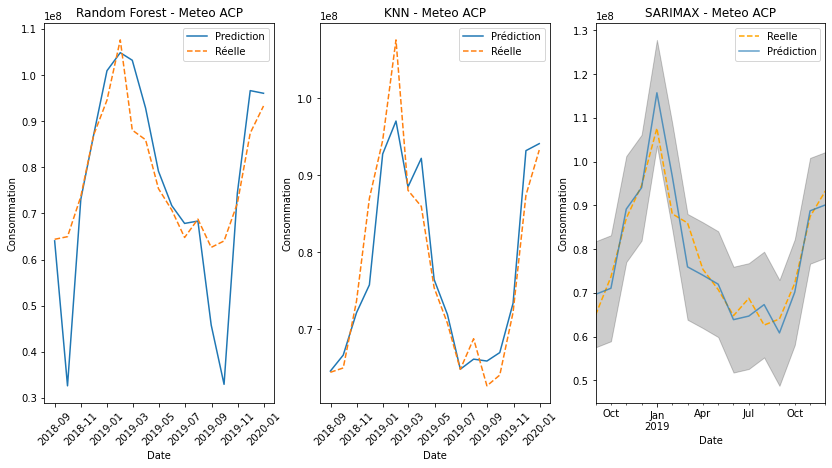

In [10]:
pred_sarima = sarima.get_prediction(start=pd.to_datetime('2018-09-30', utc=True), dynamic=False)
pred_ci = pred_sarima.conf_int()
y_pred_rf = rf.predict(X_test_scaled)
y_pred_knn = knn.predict(X_test_scaled)

plt.figure(figsize=(15,25))
plt.subplot(131)
plt.plot(y_test.index,y_pred_rf, label='Prediction')
plt.xticks(rotation=45)
plt.title('Random Forest - Meteo ACP')
plt.plot(y_test, label='Réelle', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Consommation')
plt.legend()

plt.subplot(132)
plt.plot(y_test.index, y_pred_knn, label='Prédiction')
plt.xticks(rotation=45)
plt.plot(y_test, label='Réelle', linestyle='dashed')
plt.title('KNN - Meteo ACP')
plt.xlabel('Date')
plt.ylabel('Consommation')
plt.legend()

plt.subplot(133)
ax = df_mois['2018-09-30':].plot(label='Reelle', style='--', color='orange', title = 'SARIMAX - Meteo ACP')
pred_sarima.predicted_mean.plot(ax=ax, label='Prédiction', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Consommation')
plt.legend()
plt.show()

# MAPE des modèles : 

In [11]:
print(f'Best Parameters RF: {rf.best_params_}')
train_score = mean_absolute_percentage_error(y_true=y_train, y_pred=rf.predict(X_train_scaled))
test_score = mean_absolute_percentage_error(y_true=y_test, y_pred=rf.predict(X_test_scaled))
print('Training MAPE RF:',round(train_score*100,2), '%')
print('Test MAPE RF:', round(test_score*100,2), '%')


print(f'Best Parameters KNN: {knn.best_params_}')
train_score = mean_absolute_percentage_error(y_true=y_train, y_pred=knn.predict(X_train_scaled))
test_score = mean_absolute_percentage_error(y_true=y_test, y_pred=knn.predict(X_test_scaled))
print('Training MAPE KNN:',round(train_score*100,2), '%')
print('Test MAPE KNN:', round(test_score*100,2), '%')

pred_mean = pred_sarima.predicted_mean
print('Best Parameters',best_params, 'AIC :', params_results[best_params])
train_score = mean_absolute_percentage_error(y_true=df_mois['2018-09-30':], y_pred=pred_mean)
print('MAPE SARIMA:',round(train_score*100,2), '%')

Best Parameters RF: {'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 10}
Training MAPE RF: 467.44 %
Test MAPE RF: 11.14 %
Best Parameters KNN: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
Training MAPE KNN: 0.0 %
Test MAPE KNN: 3.71 %
Best Parameters ARIMA(0, 1, 0)x(0, 1, 1, 12)12 AIC : 2499.0
MAPE SARIMA: 4.61 %


Les prédictions semblent moins fiable avec le dataset réduit via ACP.

**quand est-il par jours ?**

# Etude par jours

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df_acp_jours, df_jours, test_size=0.2, shuffle = False)

### Boucle pour paramètres :

*Nous utilisons le dictionnaire déjà créé ci-dessus.*

In [13]:
warnings.filterwarnings("ignore")

outer_cv = KFold(2)
scaler = StandardScaler()
outer_scores = {}

print('Calcul en cours...')
for keys, value in gridcvs.items():
    X_train_scaled =scaler.fit_transform(X_train)
    score = cross_val_score(value, X_train_scaled, y_train, cv = outer_cv)
    outer_scores[keys] = score
    print(f'{keys}:  R² = {100*score.mean():.2f} +/- {100*score.std():.2f}') 
print('Calcul terminé !')

Calcul en cours...
PLSRegression:  R² = 71.70 +/- 0.80
RF:  R² = 82.09 +/- 1.36
KNN:  R² = 78.83 +/- 0.94
Calcul terminé !


### Scaling et entrainement:

In [14]:
X_train_scaled =scaler.fit_transform(X_train)
X_test_scaled =scaler.fit_transform(X_test)

rf = gridcvs['RF'].fit(X_train_scaled, y_train)
knn = gridcvs['KNN'].fit(X_train_scaled, y_train)

### SARIMA

*La différenciation pour le coeff de saisonnalité s'est fait par ailleurs dans les autres notebooks, periode = 7*

In [15]:
import warnings
warnings.filterwarnings('ignore')
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]
df_acp_jours = scaler.fit_transform(df_acp_jours)
params_results = {}
print("Calcul en cours...")

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_jours,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            exog = df_acp_jours
                                            )
            results = mod.fit()
            params_results['ARIMA{}x{}7'.format(param, param_seasonal)] = round(results.aic, 0)
        except:
            continue
best_params = min(params_results, key=params_results.get)

print(best_params, 'AIC :', params_results[best_params])
print("Calcul terminé.")

Calcul en cours...
ARIMA(0, 1, 0)x(1, 1, 1, 7)7 AIC : 65535.0
Calcul terminé.


In [16]:
model=sm.tsa.SARIMAX(df_jours, order=(0,1,0) ,seasonal_order = (1, 1, 1, 7), exog=df_acp_jours)
sarima=model.fit()

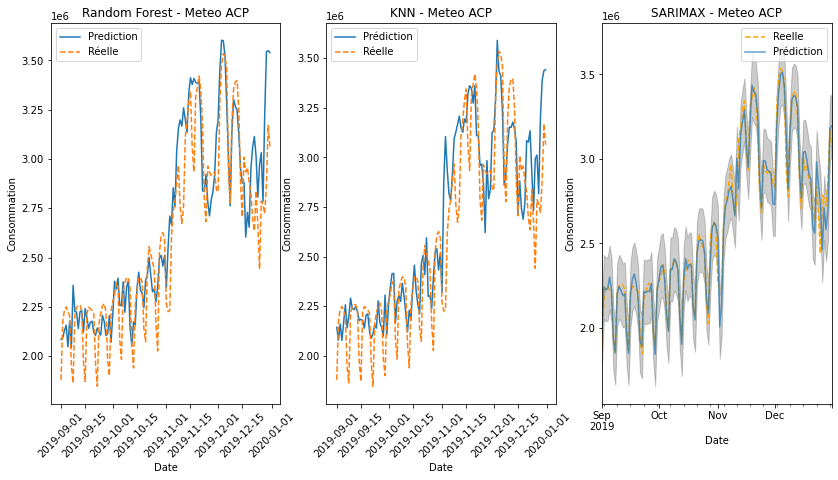

In [17]:
pred_sarima = sarima.get_prediction(start=pd.to_datetime('2019-09-01', utc=True), dynamic=False)
pred_ci = pred_sarima.conf_int()
y_pred_rf = rf.predict(X_test_scaled)
y_pred_knn = knn.predict(X_test_scaled)

plt.figure(figsize=(15,25))
plt.subplot(131)
plt.plot(y_test['2019-09-01':].index, y_pred_rf[390:], label='Prediction')
plt.title('Random Forest - Meteo ACP')
plt.plot(y_test['2019-09-01':], label='Réelle', linestyle='dashed')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Consommation')
plt.legend()

plt.subplot(132)
plt.plot(y_test['2019-09-01':].index,y_pred_knn[390:], label='Prédiction')
plt.plot(y_test['2019-09-01':], label='Réelle', linestyle='dashed')
plt.title('KNN - Meteo ACP')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Consommation')
plt.legend()

plt.subplot(133)
ax = df_jours['2019-09-01':].plot(label='Reelle', style='--', color='orange', title = 'SARIMAX - Meteo ACP')
pred_sarima.predicted_mean.plot(ax=ax, label='Prédiction', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Consommation')
plt.legend()
plt.show()

# MAPE des modèles :

In [18]:
print(f'Best Parameters RF: {rf.best_params_}')
train_score = mean_absolute_percentage_error(y_true=y_train, y_pred=rf.predict(X_train_scaled))
test_score = mean_absolute_percentage_error(y_true=y_test, y_pred=rf.predict(X_test_scaled))
print('Training MAPE RF:',round(train_score*100,2), '%')
print('Test MAPE RF:', round(test_score*100,2), '%')


print(f'Best Parameters KNN: {knn.best_params_}')
train_score = mean_absolute_percentage_error(y_true=y_train, y_pred=knn.predict(X_train_scaled))
test_score = mean_absolute_percentage_error(y_true=y_test, y_pred=knn.predict(X_test_scaled))
print('Training MAPE KNN:',round(train_score*100,2), '%')
print('Test MAPE KNN:', round(test_score*100,2), '%')

pred_mean = pred_sarima.predicted_mean
print('Best Parameters',best_params, 'AIC :', params_results[best_params])
train_score = mean_absolute_percentage_error(y_true=df_jours['2019-09-01':], y_pred=pred_mean)
print('MAPE SARIMA:',round(train_score*100,2), '%')

Best Parameters RF: {'max_features': 'auto', 'min_samples_leaf': 5, 'n_estimators': 1000}
Training MAPE RF: 6.96 %
Test MAPE RF: 6.99 %
Best Parameters KNN: {'metric': 'minkowski', 'n_neighbors': 18, 'weights': 'distance'}
Training MAPE KNN: 0.0 %
Test MAPE KNN: 7.21 %
Best Parameters ARIMA(0, 1, 0)x(1, 1, 1, 7)7 AIC : 65535.0
MAPE SARIMA: 2.16 %


KNN & RF s'en sortent aussi pas mal mais semblent ne pas bien traiter l'effet de saisonnalité. (pas comme SARIMAX)

# Granularité : 3 heures

Nous nous contenterons de 2 mois de données

In [19]:
X_train, X_test, y_train, y_test = train_test_split(df_acp_3h['2019-11-01':'2019-12-31'], df_3h['2019-11-01':'2019-12-31'], 
                                                    test_size=0.2, shuffle = False,)

### Boucle pour paramètres :
*Nous utilisons le dictionnaire déjà créé ci-dessus.*

In [20]:
warnings.filterwarnings("ignore")

outer_cv = KFold(2)
scaler = StandardScaler()
outer_scores = {}

print('Calcul en cours...')
for keys, value in gridcvs.items():
    X_train_scaled =scaler.fit_transform(X_train)
    score = cross_val_score(value, X_train_scaled, y_train, cv = outer_cv)
    outer_scores[keys] = score
    print(f'{keys}:  R² = {100*score.mean():.2f} +/- {100*score.std():.2f}') 
print('Calcul terminé !')

Calcul en cours...
PLSRegression:  R² = -18.03 +/- 28.85
RF:  R² = -28.91 +/- 0.19
KNN:  R² = -26.14 +/- 11.67
Calcul terminé !


### Scaling et Entrainement des modèles

In [21]:
X_train_scaled =scaler.fit_transform(X_train)
X_test_scaled =scaler.fit_transform(X_test)

rf = gridcvs['RF'].fit(X_train_scaled, y_train)
knn = gridcvs['KNN'].fit(X_train_scaled, y_train)

### SARIMAX
*periode : 8 - notebook précédent*

In [22]:
import warnings
warnings.filterwarnings('ignore')
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 8) for x in list(itertools.product(p, d, q))]
df_acp_jours = scaler.fit_transform(df_acp_jours)
params_results = {}

print("Calcul en cours...")

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_3h['2019-11-01':'2019-12-31'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            exog =df_acp_3h['2019-11-01':'2019-12-31'],
                                            )
            results = mod.fit()
            params_results['ARIMA{}x{}8'.format(param, param_seasonal)] = round(results.aic, 0)
        except:
            continue
best_params = min(params_results, key=params_results.get)

print(best_params, 'AIC :', params_results[best_params])
print("Calcul terminé.")

Calcul en cours...
ARIMA(1, 1, 1)x(1, 1, 1, 8)8 AIC : 10404.0
Calcul terminé.


In [23]:
model=sm.tsa.SARIMAX(df_3h['2019-11-01':'2019-12-31'], order=(1,1,1) ,seasonal_order = (1, 1, 1, 8), exog = df_acp_3h['2019-11-01':'2019-12-31'])
sarima=model.fit()

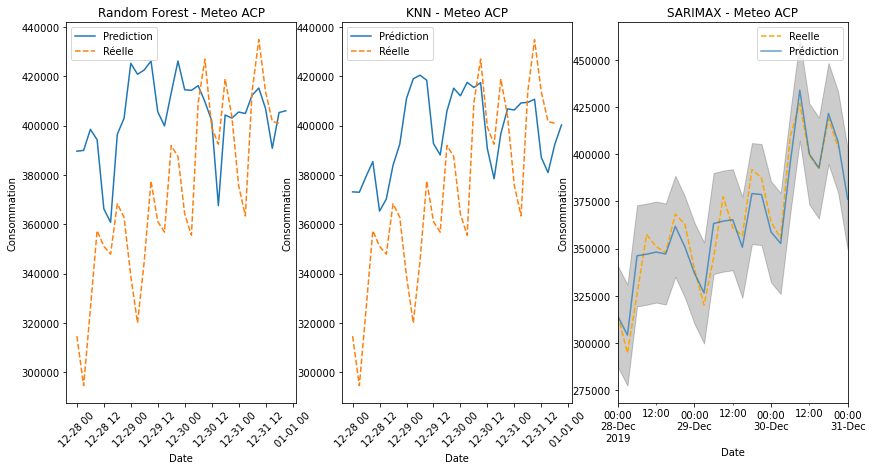

In [24]:
pred_sarima = sarima.get_prediction(start=pd.to_datetime('2019-12-28', utc= True),end=pd.to_datetime('2019-12-31', utc= True), dynamic=False)
pred_ci = pred_sarima.conf_int()
y_pred_rf = rf.predict(X_test_scaled)
y_pred_knn = knn.predict(X_test_scaled)

plt.figure(figsize=(15,25))
plt.subplot(131)
plt.plot(y_test['2019-12-28':].index, y_pred_rf[66:], label='Prediction')
plt.title('Random Forest - Meteo ACP')
plt.plot(y_test['2019-12-28 00:00:00+00:00':'2019-12-31 18:00:00+00:00'], label='Réelle', linestyle='dashed')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Consommation')
plt.legend()

plt.subplot(132)
plt.plot(y_test['2019-12-28':].index, y_pred_knn[66:], label='Prédiction')
plt.plot(y_test['2019-12-28 00:00:00+00:00':'2019-12-31 18:00:00+00:00'], label='Réelle', linestyle='dashed')
plt.title('KNN - Meteo ACP')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Consommation')
plt.legend()

plt.subplot(133)
ax = df_3h['2019-12-28':'2019-12-30'].plot(label='Reelle', style='--', color='orange', title = 'SARIMAX - Meteo ACP')
pred_sarima.predicted_mean.plot(ax=ax, label='Prédiction', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Consommation')
plt.legend()
plt.show()

In [25]:
print(f'Best Parameters RF: {rf.best_params_}')
train_score = mean_absolute_percentage_error(y_true=y_train, y_pred=rf.predict(X_train_scaled))
test_score = mean_absolute_percentage_error(y_true=y_test, y_pred=rf.predict(X_test_scaled))
print('Training MAPE RF:',round(train_score*100,2), '%')
print('Test MAPE RF:', round(test_score*100,2), '%')


print(f'Best Parameters KNN: {knn.best_params_}')
train_score = mean_absolute_percentage_error(y_true=y_train, y_pred=knn.predict(X_train_scaled))
test_score = mean_absolute_percentage_error(y_true=y_test, y_pred=knn.predict(X_test_scaled))
print('Training MAPE KNN:',round(train_score*100,2), '%')
print('Test MAPE KNN:', round(test_score*100,2), '%')

pred_mean = pred_sarima.predicted_mean
print('Best Parameters',best_params, 'AIC :', params_results[best_params])
train_score = mean_absolute_percentage_error(y_true=df_3h['2019-12-28':'2019-12-30'], y_pred=pred_mean['2019-12-28':'2019-12-30'])
print('MAPE SARIMA:',round(train_score*100,2), '%')

Best Parameters RF: {'max_features': 'log2', 'min_samples_leaf': 5, 'n_estimators': 100}
Training MAPE RF: 6.7 %
Test MAPE RF: 9.94 %
Best Parameters KNN: {'metric': 'manhattan', 'n_neighbors': 40, 'weights': 'uniform'}
Training MAPE KNN: 9.81 %
Test MAPE KNN: 9.79 %
Best Parameters ARIMA(1, 1, 1)x(1, 1, 1, 8)8 AIC : 10404.0
MAPE SARIMA: 1.98 %
